# Taxi Demand Prediction - Neural Network
---
In this notebook, we build a model for predicting taxi demand in Chicago. The model is based on the information provided by the city of Chicago in 2015. 

Furthermore, the model is based on all of the available data. Since we use mini batches to train the neural network and the prediction target is taxi demand which is calculated by data aggregation. We won't encounter any memory problems. 

To build our demand prediction model, we proceed as following:


In [1]:
cd ..

C:\Users\Sepehr\Desktop\Master\AdvanceAnalyticsAndApps\project\aaa21\aaa21


In [4]:
import utils, feature_engineering, geo_engineering,preprocessing,prediction_nn,prediction_utils
import pandas as pd
import numpy as np
from fastai.tabular.all import *
import matplotlib.pyplot as plt
%matplotlib inline

# Daily Models
---
Explanations...

## Data Preparation
---

In [3]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet', 
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

daily_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D')
daily_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
                                            use_hexes=True,hex_resolution=7)
daily_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='D',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Daily Model - Community Areas
---
Explanation

In [4]:
#Train - Test - Validation Split
train_val_dls,test_dl = prediction_nn.split_data_sets_for_nn(daily_demand,temporal_resolution='D',
                                                test_size=0.2,batch_size=512,validation_size=0.2)

In [5]:
daily_model = tabular_learner(train_val_dls, layers=[100,50],
                n_out=1, loss_func=L1LossFlat(), opt_func=Adam, lr=0.001,
                metrics=[mse,rmse,R2Score()],
                train_bn=True, moms=(0.95, 0.85, 0.95))

SuggestedLRs(lr_min=0.02570395767688751, lr_steep=0.00011220184387639165)

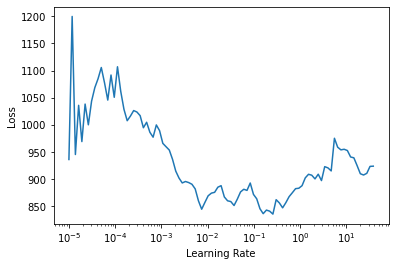

In [18]:
daily_model.lr_find(start_lr = 1e-05,end_lr = 1e+02, num_it = 100)

In [6]:
daily_model.summary()

TabularModel (Input shape: 64 x torch.Size([64, 9]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 18             
Embedding                                 1404       True      
____________________________________________________________________________
                     64 x 2              
Embedding                                 4          True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 45         True      
Embedding                                 40         True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                           

epoch,train_loss,valid_loss,mse,_rmse,r2_score,time
0,957.715088,824.265930,9625976.000000,3102.575684,-0.075942,00:04
1,942.624268,822.094055,9621024.000000,3101.777832,-0.075389,00:04
2,903.463623,815.203247,9598864.000000,3098.203125,-0.072911,00:04
3,889.725952,796.742249,9521688.000000,3085.723145,-0.064285,00:04
4,894.410950,756.289307,9287644.000000,3047.563721,-0.038125,00:05
5,829.123413,697.748230,8783781.000000,2963.744141,0.018194,00:04
6,727.181335,614.513000,7808695.000000,2794.404053,0.127184,00:04
7,639.604065,615.144714,6452829.500000,2540.241699,0.278736,00:03
8,579.580933,461.988922,4936035.500000,2221.718994,0.448275,00:04
9,458.574432,548.141968,2963339.500000,1721.435547,0.668773,00:06


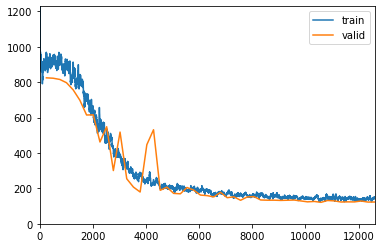

In [7]:
daily_model.fit_one_cycle(50,cbs=[ShowGraphCallback()])

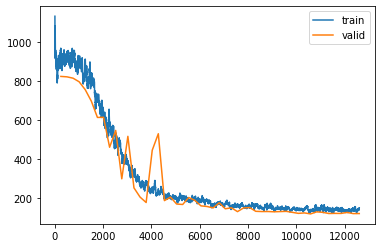

In [8]:
daily_model.recorder.plot_loss()

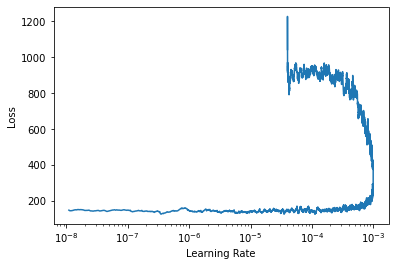

In [9]:
#Plotting Learning Rate
daily_model.recorder.plot_lr_find()

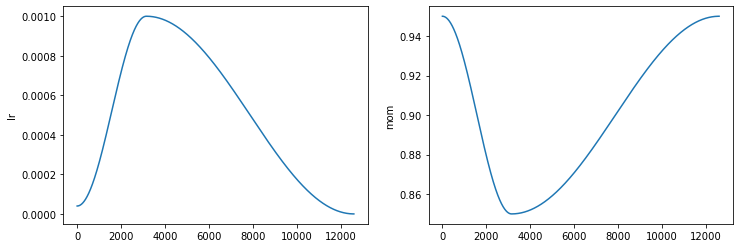

In [10]:
# Plotting momentom
daily_model.recorder.plot_sched()

In [25]:
prediction = daily_model.get_preds(dl=test_dl)
prediction_utils.get_prediction_scores(y_true=prediction[0],y_predicted=prediction[1])

-------MODEL SCORES-------
MAE:  293.838
MSE:  1387868.360
RMSE:  1178.078
R2:  85.412 %


#### Hyper Parameter Tuning
---

### Daily Model - Hex 7
---
Explanation

### Daily Model - Hex 6
---
Explanation

In [ ]:
#Memory Cleaning
del daily_demand
del daily_demand_hex_6
del daily_demand_hex_7

# 6H Models
---
Explanations...

## Data Preparation
---

In [ ]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet', 
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

six_hour_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H')
six_hour_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H',
                                            use_hexes=True,hex_resolution=7)
six_hour_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='6H',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### 6H Model - Community Areas
---
Explanation

#### Hyper Parameter Tuning
---

### 6H Model - Hex 7
---
Explanation

### 6H Model - Hex 6
---
Explanation

In [ ]:
#Memory Cleaning
del six_hour_demand
del six_hour_demand_hex_6
del six_hour_demand_hex_7

# Hourly Models
---
Explanations...

## Data Preparation
---

In [ ]:
# Takes few minutes to run (16 GB RAM)
chicago_df = utils.read_parquet('Taxi_Trips_Cleaned.parquet', 
                                columns=['Trip ID','Trip Start Timestamp','Pickup Community Area',
                                         'Dropoff Community Area'])
weather_df = utils.read_parquet('Weather.parquet',columns = ['Trip Start Timestamp','Humidity(%)',
                                    'Pressure(hPa)','Temperature(C)',
                                    'Wind Direction(Meteoro. Degree)','Wind Speed(M/S)'])

hourly_demand = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H')
hourly_demand_hex_7 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H',
                                            use_hexes=True,hex_resolution=7)
hourly_demand_hex_6 = preprocessing.create_aggregated_data(df=chicago_df,weather_df=weather_df,temporal_resolution='H',
                                            use_hexes=True,hex_resolution=6)

del chicago_df
del weather_df

### Hourly Model - Community Areas
---
Explanation

#### Hyper Parameter Tuning
---

### Hourly Model - Hex 7
---
Explanation

### Hourly Model - Hex 6
---
Explanation

## Overall Scores & Outlook
---